In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/deeplearning_with_pytorch")

Mounted at /content/drive


# Using convolutions to generalize

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)

## import dataset and use bird and airplane only

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
from torchvision import datasets, transforms
data_path = './data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
# choose only airplane and bird to put in the model
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

## Regular connected / softmax model

In [ ]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

In [ ]:
numel_list = [p.numel() for p in connected_model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [ ]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [ ]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [ ]:
# linear layer shape
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

## Using Convolution

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [ ]:
# without padding, the image shrinks a bit
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

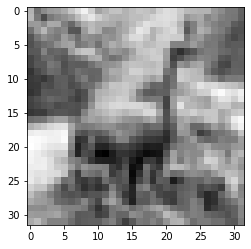

In [ ]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

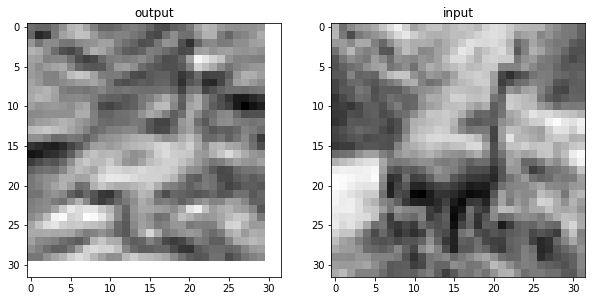

In [ ]:
# the output image shrunk due to the kernel size
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [ ]:
# add padding
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [ ]:
# lets zero out bias and use average kernel

with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

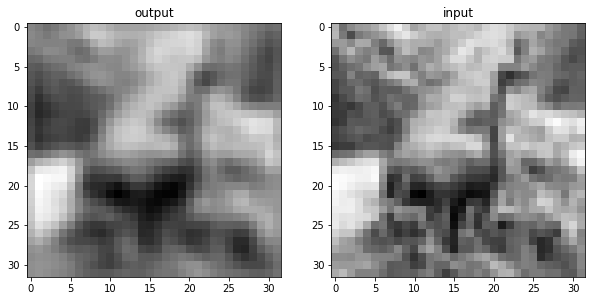

In [ ]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [ ]:
# vertical line filter
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

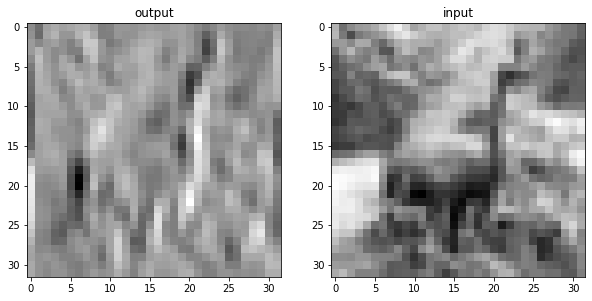

In [ ]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title('input')
plt.show()

In [ ]:
# MaxPool is used to shrink the size
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 3 channels in 16 channels out
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [ ]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
# subclass model has more flexibility
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc3 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
import torch.nn.functional as F

# above looks a bit messy, clear out by using functional layers in forward
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0055, -0.0499]], grad_fn=<AddmmBackward>)

In [ ]:
# run through training loop
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)
            ))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2021-05-07 11:27:26.141098 Epoch 1, Training loss 0.5788762559936305
2021-05-07 11:27:55.321829 Epoch 10, Training loss 0.3339342659066437
2021-05-07 11:28:27.681544 Epoch 20, Training loss 0.2952260353193162
2021-05-07 11:28:59.909629 Epoch 30, Training loss 0.27093506144110563
2021-05-07 11:29:32.186950 Epoch 40, Training loss 0.24996815394064423
2021-05-07 11:30:04.281318 Epoch 50, Training loss 0.23378773066838077
2021-05-07 11:30:36.747369 Epoch 60, Training loss 0.21802070243343427
2021-05-07 11:31:08.859595 Epoch 70, Training loss 0.2038340519188316
2021-05-07 11:31:40.961831 Epoch 80, Training loss 0.18759912553771285
2021-05-07 11:32:13.209231 Epoch 90, Training loss 0.17304471588343573
2021-05-07 11:32:45.453748 Epoch 100, Training loss 0.15929172244990708


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [ ]:
# save the mddel
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [ ]:
# load the model
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt"))

<All keys matched successfully>

In [ ]:
# lets use GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device) # image to gpu
            labels = labels.to(device=device) # labels to gpu
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)
            ))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # model to gpu
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-05-07 11:39:26.935547 Epoch 1, Training loss 0.5639553838854383
2021-05-07 11:39:29.826725 Epoch 10, Training loss 0.3216142732246666
2021-05-07 11:39:32.985332 Epoch 20, Training loss 0.2912667181081833
2021-05-07 11:39:36.146407 Epoch 30, Training loss 0.2678972814872766
2021-05-07 11:39:39.310799 Epoch 40, Training loss 0.24890092043739975
2021-05-07 11:39:42.468790 Epoch 50, Training loss 0.23138021312321827
2021-05-07 11:39:45.609452 Epoch 60, Training loss 0.2198845273370196
2021-05-07 11:39:48.757136 Epoch 70, Training loss 0.2033891558504788
2021-05-07 11:39:51.881395 Epoch 80, Training loss 0.1892463041908422
2021-05-07 11:39:55.039052 Epoch 90, Training loss 0.17685912506785362
2021-05-07 11:39:58.231836 Epoch 100, Training loss 0.1624053155255925


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device) # to gpu
                labels = labels.to(device=device) # to gpu
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [ ]:
# make dictionary for comparison later
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

In [ ]:
# model with higher width, 32 channels
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2021-05-07 11:48:03.125088 Epoch 1, Training loss 0.5318438181072284
2021-05-07 11:48:06.362937 Epoch 10, Training loss 0.3170522860470851
2021-05-07 11:48:09.934937 Epoch 20, Training loss 0.2760315857305648
2021-05-07 11:48:13.467743 Epoch 30, Training loss 0.2455649082163337
2021-05-07 11:48:16.997105 Epoch 40, Training loss 0.21820110709044585
2021-05-07 11:48:20.542706 Epoch 50, Training loss 0.19158957537951743
2021-05-07 11:48:24.086683 Epoch 60, Training loss 0.16675845393614405
2021-05-07 11:48:27.621124 Epoch 70, Training loss 0.1435577762402167
2021-05-07 11:48:31.188819 Epoch 80, Training loss 0.12183491850070133
2021-05-07 11:48:34.701086 Epoch 90, Training loss 0.10151255020432791
2021-05-07 11:48:38.232853 Epoch 100, Training loss 0.08304764883248669
Accuracy train: 0.97
Accuracy val: 0.90


{'train': 0.9687, 'val': 0.899}

In [ ]:
# number of channels as hyper parameter
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2021-05-07 11:49:23.805878 Epoch 1, Training loss 0.5312573300425414
2021-05-07 11:49:27.028265 Epoch 10, Training loss 0.3177052797975054
2021-05-07 11:49:30.574462 Epoch 20, Training loss 0.2750591999216444
2021-05-07 11:49:34.095668 Epoch 30, Training loss 0.2417116636873051
2021-05-07 11:49:37.629565 Epoch 40, Training loss 0.21444194858810703
2021-05-07 11:49:41.164844 Epoch 50, Training loss 0.1908200139025594
2021-05-07 11:49:44.690869 Epoch 60, Training loss 0.16872439561945618
2021-05-07 11:49:48.229786 Epoch 70, Training loss 0.14754215108266303
2021-05-07 11:49:51.785428 Epoch 80, Training loss 0.12734715976295577
2021-05-07 11:49:55.314914 Epoch 90, Training loss 0.10823720627149959
2021-05-07 11:49:58.849919 Epoch 100, Training loss 0.09049647994292011
Accuracy train: 0.96
Accuracy val: 0.89


## Regularization

In [ ]:
# l2 regularization
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [ ]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2021-05-07 11:59:12.118422 Epoch 1, Training loss 0.5818778604838499
2021-05-07 11:59:16.109459 Epoch 10, Training loss 0.3514294591109464
2021-05-07 11:59:20.504021 Epoch 20, Training loss 0.3224465164599145
2021-05-07 11:59:24.879775 Epoch 30, Training loss 0.30078875762262164
2021-05-07 11:59:29.239109 Epoch 40, Training loss 0.28163740570378154
2021-05-07 11:59:33.641908 Epoch 50, Training loss 0.2645878493785858
2021-05-07 11:59:37.971112 Epoch 60, Training loss 0.25034529786960336
2021-05-07 11:59:42.319075 Epoch 70, Training loss 0.2386040915824046
2021-05-07 11:59:46.681372 Epoch 80, Training loss 0.22849219430024456
2021-05-07 11:59:51.044370 Epoch 90, Training loss 0.21946098565296002
2021-05-07 11:59:55.378125 Epoch 100, Training loss 0.21101561872063168
Accuracy train: 0.91
Accuracy val: 0.89


In [ ]:
# drop out (add probability)
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2021-05-07 12:09:01.550135 Epoch 1, Training loss 0.5697792852000826
2021-05-07 12:09:04.964196 Epoch 10, Training loss 0.3874285659592622
2021-05-07 12:09:08.769653 Epoch 20, Training loss 0.3539437996164249
2021-05-07 12:09:12.559524 Epoch 30, Training loss 0.33041071692469776
2021-05-07 12:09:16.325319 Epoch 40, Training loss 0.3162948522408297
2021-05-07 12:09:20.113542 Epoch 50, Training loss 0.30534745990091067
2021-05-07 12:09:23.912629 Epoch 60, Training loss 0.289710868695739
2021-05-07 12:09:27.675000 Epoch 70, Training loss 0.2759953399372708
2021-05-07 12:09:31.456661 Epoch 80, Training loss 0.2700607784234794
2021-05-07 12:09:35.248964 Epoch 90, Training loss 0.25405612246246095
2021-05-07 12:09:39.048782 Epoch 100, Training loss 0.24612413156943716
Accuracy train: 0.89
Accuracy val: 0.89


In [ ]:
# batch normalization
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2021-05-07 12:11:52.848168 Epoch 1, Training loss 0.4762273628240938
2021-05-07 12:11:56.675065 Epoch 10, Training loss 0.26740449277838324
2021-05-07 12:12:00.918942 Epoch 20, Training loss 0.20537060356823503
2021-05-07 12:12:05.145888 Epoch 30, Training loss 0.15573459381985058
2021-05-07 12:12:09.404150 Epoch 40, Training loss 0.11118030975199049
2021-05-07 12:12:13.625015 Epoch 50, Training loss 0.0744691591140381
2021-05-07 12:12:17.875811 Epoch 60, Training loss 0.047611692131372396
2021-05-07 12:12:22.153988 Epoch 70, Training loss 0.034461301484495215
2021-05-07 12:12:26.400185 Epoch 80, Training loss 0.022800981200590823
2021-05-07 12:12:30.648651 Epoch 90, Training loss 0.01387762105994069
2021-05-07 12:12:34.885313 Epoch 100, Training loss 0.008581890754259316
Accuracy train: 0.98
Accuracy val: 0.88


In [ ]:
# greater depth
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2021-05-07 12:12:43.682869 Epoch 1, Training loss 0.6661899556779558
2021-05-07 12:12:47.267940 Epoch 10, Training loss 0.35228476981828166
2021-05-07 12:12:51.241086 Epoch 20, Training loss 0.30367679020781424
2021-05-07 12:12:55.216765 Epoch 30, Training loss 0.26919753080720354
2021-05-07 12:12:59.188481 Epoch 40, Training loss 0.23435764014720917
2021-05-07 12:13:03.169638 Epoch 50, Training loss 0.20314105400803742
2021-05-07 12:13:07.182891 Epoch 60, Training loss 0.17395968483701632
2021-05-07 12:13:11.150218 Epoch 70, Training loss 0.14666369597718215
2021-05-07 12:13:15.112303 Epoch 80, Training loss 0.11993113767569231
2021-05-07 12:13:19.066292 Epoch 90, Training loss 0.09470987285540741
2021-05-07 12:13:23.030076 Epoch 100, Training loss 0.07112885032821993
Accuracy train: 0.95
Accuracy val: 0.89


In [ ]:
# ResNet Model
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4* n_chans1 //2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4* self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2021-05-07 12:19:16.811182 Epoch 1, Training loss 0.6636945195258803
2021-05-07 12:19:20.493103 Epoch 10, Training loss 0.3209313707556694
2021-05-07 12:19:24.482100 Epoch 20, Training loss 0.2761925509211364
2021-05-07 12:19:28.519115 Epoch 30, Training loss 0.23998405665728698
2021-05-07 12:19:32.524003 Epoch 40, Training loss 0.21051051159193562
2021-05-07 12:19:36.606540 Epoch 50, Training loss 0.18419552077153686
2021-05-07 12:19:40.630863 Epoch 60, Training loss 0.1586772002706862
2021-05-07 12:19:44.619953 Epoch 70, Training loss 0.1332323689512007
2021-05-07 12:19:48.615022 Epoch 80, Training loss 0.10682999826730437
2021-05-07 12:19:52.606828 Epoch 90, Training loss 0.08391297119817916
2021-05-07 12:19:56.637863 Epoch 100, Training loss 0.06230737518068332
Accuracy train: 0.96
Accuracy val: 0.90


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [ ]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2021-05-07 12:30:23.520025 Epoch 1, Training loss 2.100278320585846
2021-05-07 12:31:45.803078 Epoch 10, Training loss 0.32332368403862993
2021-05-07 12:33:16.923375 Epoch 20, Training loss 0.2371314604096352
2021-05-07 12:34:48.172294 Epoch 30, Training loss 0.17133655728902786
2021-05-07 12:36:19.471441 Epoch 40, Training loss 0.12531390143143142
2021-05-07 12:37:50.893850 Epoch 50, Training loss 0.09108960395382279
2021-05-07 12:39:22.452318 Epoch 60, Training loss 0.0774686412328178
2021-05-07 12:40:53.697122 Epoch 70, Training loss 0.05115112455585485
2021-05-07 12:42:24.780145 Epoch 80, Training loss 0.05601789519950083
2021-05-07 12:43:56.015649 Epoch 90, Training loss 0.02649548287788157
2021-05-07 12:45:27.309942 Epoch 100, Training loss 0.04654821697370428
Accuracy train: 0.95
Accuracy val: 0.86
